In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados (usando o dataset combinado que criamos anteriormente)
# df = pd.read_csv('atp_matches_1992-2024_with_elo.csv')

# Ou começar do zero com os dados originais
df = pd.concat([pd.read_csv(f'D:/projetos/Tenis ML-AI/data/tennis_atp/atp_matches_{year}.csv') for year in range(1992, 2025)])

# Definir as superfícies
surfaces = df['surface'].unique().tolist()
print("Superfícies encontradas:", surfaces)

# Parâmetros do ELO
K_FACTOR = 32  # Fator de ajuste do ELO
INITIAL_ELO = 1500  # ELO inicial para todos os jogadores

# Dicionário para armazenar os ELOs por superfície
elo_by_surface = {}

# Inicializar ELOs para cada superfície
for surface in surfaces:
    if pd.isna(surface):
        continue
    elo_by_surface[surface] = {}

# Função para calcular a probabilidade esperada
def expected_score(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

# Função para atualizar o ELO
def update_elo(winner_elo, loser_elo, K=K_FACTOR):
    expected_win = expected_score(winner_elo, loser_elo)
    change = K * (1 - expected_win)
    winner_elo += change
    loser_elo -= change
    return winner_elo, loser_elo

# Processar cada partida em ordem cronológica
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
df = df.sort_values('tourney_date')

# Inicializar dicionário para armazenar o ELO atual de cada jogador por superfície
current_elo = {surface: {} for surface in elo_by_surface.keys()}

# Listas para armazenar os ELOs durante o processamento
winner_elos = []
loser_elos = []

for idx, row in df.iterrows():
    surface = row['surface']
    if pd.isna(surface):
        winner_elos.append(np.nan)
        loser_elos.append(np.nan)
        continue
    
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    
    # Obter ELO atual ou usar o inicial
    winner_elo = current_elo[surface].get(winner_id, INITIAL_ELO)
    loser_elo = current_elo[surface].get(loser_id, INITIAL_ELO)
    
    # Armazenar ELOs antes da atualização
    winner_elos.append(winner_elo)
    loser_elos.append(loser_elo)
    
    # Atualizar ELOs
    new_winner_elo, new_loser_elo = update_elo(winner_elo, loser_elo)
    
    # Atualizar no dicionário
    current_elo[surface][winner_id] = new_winner_elo
    current_elo[surface][loser_id] = new_loser_elo

# Adicionar colunas de ELO por superfície ao DataFrame
df['winner_surface_elo'] = winner_elos
df['loser_surface_elo'] = loser_elos

# Salvar os resultados
df.to_csv('atp_matches_with_surface_elo.csv', index=False)

Superfícies encontradas: ['Hard', 'Carpet', 'Clay', 'Grass', nan]


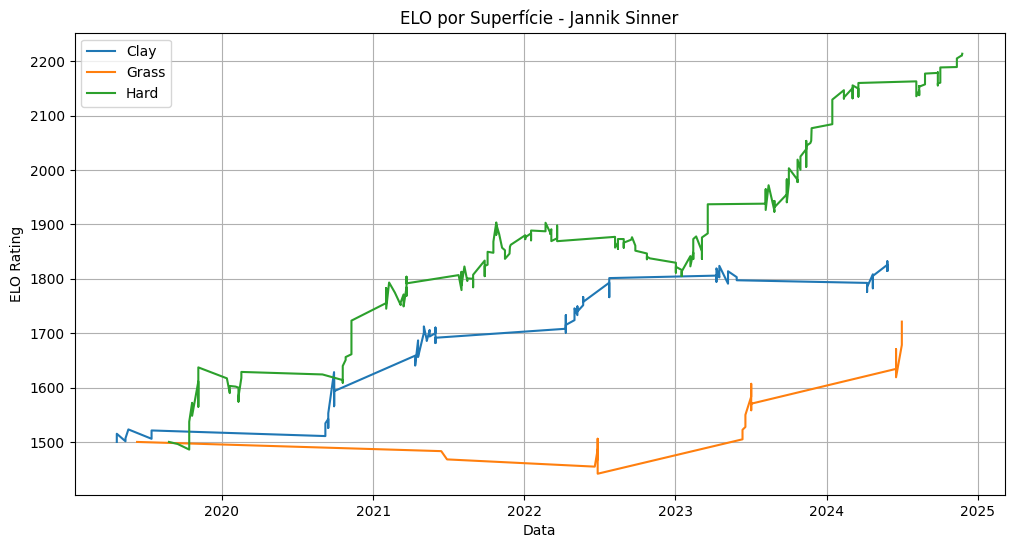

In [7]:
import matplotlib.pyplot as plt

# Exemplo: Pegar um jogador específico e plotar seu ELO por superfície ao longo do tempo
player_name = "Jannik Sinner"  # Substitua pelo nome do jogador desejado
player_id = df[df['winner_name'] == player_name]['winner_id'].iloc[0]

# Criar DataFrame com histórico do jogador
player_history = pd.concat([
    df[df['winner_id'] == player_id][['tourney_date', 'surface', 'winner_surface_elo']].rename(
        columns={'winner_surface_elo': 'surface_elo'}),
    df[df['loser_id'] == player_id][['tourney_date', 'surface', 'loser_surface_elo']].rename(
        columns={'loser_surface_elo': 'surface_elo'})
]).sort_values('tourney_date')

# Plotar
plt.figure(figsize=(12, 6))
for surface in player_history['surface'].unique():
    if pd.isna(surface):
        continue
    surface_data = player_history[player_history['surface'] == surface]
    plt.plot(surface_data['tourney_date'], surface_data['surface_elo'], label=surface)

plt.title(f'ELO por Superfície - {player_name}')
plt.xlabel('Data')
plt.ylabel('ELO Rating')
plt.legend()
plt.grid()
plt.savefig(f'D:/projetos/Tenis ML-AI/figures/{player_name}_elo_by_surface.png')
plt.show()
plt.close()